In [ ]:
!pip install opencv-python

In [ ]:
!pip install PyWavelets

In [ ]:
!pip install pyiqa

In [ ]:
!pip install -U scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:
import cv2
import os
import torch
import imageio
import scipy.io as sio
from google.colab import drive
import torch.nn.functional as F
import numpy as np
#from scipy.ndimage import convolve
import pywt
#from skimage.color import rgb2ycbcr, ycbcr2rgb
#from torchvision.transforms.functional import rgb_to_grayscale
import sys
#from lpips import LPIPS
from skimage.measure import shannon_entropy

from torch.autograd import Variable
#from PIL import Image
import time, math
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = "/content/drive/My Drive/MFSR"
video_filename = os.path.join(drive_path, "Video.avi")
frame_folder = os.path.join(drive_path, "Vid4/walk")
model_folder = os.path.join(drive_path, "model")  # Fixed path

# Ensure model folder exists
if not os.path.exists(model_folder):
    print(f"❌ Model folder not found: {model_folder}")
else:
    print(f"✅ Model folder found: {model_folder}")

sys.path.append('/content/drive/My Drive/MFSR')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model folder found: /content/drive/My Drive/MFSR/model


In [ ]:

def modcrop(imgs: np.ndarray, modulo: int) -> np.ndarray:
    """
    Crop the input image so that its height and width are multiples of `modulo`.
    Supports both grayscale (H, W) and RGB (H, W, C) images.

    Args:
        imgs (np.ndarray): Input image array (H, W) for grayscale or (H, W, C) for color.
        modulo (int): The modulo value to crop the image dimensions.

    Returns:
        np.ndarray: Cropped image array.
    """
    if imgs.ndim == 2:  # Grayscale image (H, W)
        h, w = imgs.shape
        h -= h % modulo
        w -= w % modulo
        return imgs[:h, :w]

    elif imgs.ndim == 3:  # RGB image (H, W, C)
        h, w, c = imgs.shape
        h -= h % modulo
        w -= w % modulo
        return imgs[:h, :w, :]

    else:
        raise ValueError("Input must be a 2D (H, W) or 3D (H, W, C) NumPy array.")


In [ ]:
def shave(I, border):
    """
    Crop the border of an image tensor/array.

    Args:
        I (np.ndarray or torch.Tensor): Input image.
        border (tuple): Tuple (border_h, border_w) specifying the amount to shave from height and width.

    Returns:
        np.ndarray or torch.Tensor: Shaved image.
    """
    if isinstance(I, torch.Tensor):
        I = I.numpy()  # Convert PyTorch tensor to NumPy array

    if I.ndim == 2:  # Grayscale image (H, W)
        return I[border[0]:-border[0], border[1]:-border[1]]
    elif I.ndim == 3:  # Color image (H, W, C)
        return I[border[0]:-border[0], border[1]:-border[1], :]
    else:
        raise ValueError("Input must be a 2D (H, W) or 3D (H, W, C) image.")


In [ ]:
def SRCNN(model, im_b):
    """
    Perform Super-Resolution using a pre-trained SRCNN model.
    """
    import torch.nn.functional as F

    # Convert im_b to a PyTorch tensor
    im_b = torch.from_numpy(im_b).double().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions


    # Load model parameters as PyTorch tensors
    weights_conv1 = torch.tensor(model['weights_conv1'], dtype=torch.float64)
    biases_conv1 = torch.tensor(model['biases_conv1'], dtype=torch.float64).view(-1)
    weights_conv2 = torch.tensor(model['weights_conv2'], dtype=torch.float64)
    biases_conv2 = torch.tensor(model['biases_conv2'], dtype=torch.float64).view(-1)
    weights_conv3 = torch.tensor(model['weights_conv3'], dtype=torch.float64)
    biases_conv3 = torch.tensor(model['biases_conv3'], dtype=torch.float64).view(-1)



    # Get dimensions
    conv1_patchsize = int(weights_conv1.shape[0] ** 0.5)
    conv1_filters = weights_conv1.shape[1]
    conv2_channels, conv2_patchsize2, conv2_filters = weights_conv2.shape
    conv2_patchsize = int(conv2_patchsize2 ** 0.5)
    conv3_channels, conv3_patchsize2 = weights_conv3.shape
    conv3_patchsize = int(conv3_patchsize2 ** 0.5)

    # Conv1
    weights_conv1 = weights_conv1.permute(1, 0).reshape(conv1_filters, 1, conv1_patchsize, conv1_patchsize)
    conv1_data = F.conv2d(im_b, weights_conv1, bias=biases_conv1, padding=conv1_patchsize // 2)
    conv1_data = torch.maximum(conv1_data, torch.tensor(0.15))

    # Conv2
    weights_conv2 = weights_conv2.permute(2, 0, 1).reshape(conv2_filters, conv2_channels, conv2_patchsize, conv2_patchsize)
    conv2_data = F.conv2d(conv1_data, weights_conv2, bias=biases_conv2, padding=conv2_patchsize // 2)
    conv2_data = torch.maximum(conv2_data, torch.tensor(0.0))

    # Conv3
    weights_conv3 = weights_conv3.reshape(1, conv3_channels, conv3_patchsize, conv3_patchsize)
    conv3_data = F.conv2d(conv2_data, weights_conv3, bias=biases_conv3, padding=conv3_patchsize // 2)

    # Convert back to NumPy array
    im_h = conv3_data.squeeze().numpy()

    return im_h


In [ ]:
# Create a video writer object
frame_size = (640, 480)  # Adjust based on input image size
writer = imageio.get_writer('Video.avi', fps=30)

# Write frames sequentially
for i in range(1, 50):  # Some number of frames
    frame_path = os.path.join(frame_folder, f"{i}.png")
    if os.path.exists(frame_path):
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, frame_size)  # Resize if needed
        #writer.write(frame)
        writer.append_data(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
        print(f"⚠️ Frame {frame_path} not found!")

# Close the video writer object
writer.close()
print("✅ Video writing completed.")

⚠️ Frame /content/drive/My Drive/MFSR/Vid4/walk/48.png not found!
⚠️ Frame /content/drive/My Drive/MFSR/Vid4/walk/49.png not found!
✅ Video writing completed.


In [ ]:
# Set parameters
up_scale = 2
video = 'Video.avi'
wtype = 'bior1.1'
model_l_path = os.path.join(model_folder, 'L.mat')
model_h_path = os.path.join(model_folder, 'H.mat')
model_v_path = os.path.join(model_folder, 'V.mat')
model_d_path = os.path.join(model_folder, 'D.mat')
model_srcnn_path = os.path.join(model_folder, 'srcnn_x2.mat')
model_vdsr_path = os.path.join(model_folder, 'model_epoch_50.pth')

# Load model parameters
model_l = sio.loadmat(model_l_path)
model_h = sio.loadmat(model_h_path)
model_v = sio.loadmat(model_v_path)
model_d = sio.loadmat(model_d_path)
model_srcnn = sio.loadmat(model_srcnn_path)
model_vdsr = torch.load(model_vdsr_path, weights_only=False)["model"]

In [ ]:
# Read video to get metadata

org = cv2.VideoCapture(video)
n_frames = int(org.get(cv2.CAP_PROP_FRAME_COUNT))
fps = org.get(cv2.CAP_PROP_FPS)

print(f"🎥 Total Frames: {n_frames}, FPS: {fps}")

🎥 Total Frames: 47, FPS: 30.0


In [ ]:
#read video

org = cv2.VideoCapture(video)
NFrames = round(org.get(cv2.CAP_PROP_FPS) * org.get(cv2.CAP_PROP_FRAME_COUNT) / org.get(cv2.CAP_PROP_FPS))



In [ ]:
#Wavelet_SRCNN

wavelet_super = imageio.get_writer('wavelet_super_resolution.mp4', fps=30)

for i in range(NFrames):
  ret, Img = org.read()
  image1 = cv2.cvtColor(Img, cv2.COLOR_RGB2YCrCb)
  im_Y = image1[:, :, 0]

  im_gnd = modcrop(im_Y, up_scale).astype(np.float32) / 255.0
  im_low = cv2.resize(im_gnd, (im_gnd.shape[1] // up_scale, im_gnd.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC)


  cA = SRCNN(model_l, im_low)
  cH = SRCNN(model_h, im_low)
  cV = SRCNN(model_v, im_low)
  cD = SRCNN(model_d, im_low)
  im_wsr = pywt.idwt2((cA, (cH, cV, cD)), wtype)

  if up_scale == 4:
    cA = SRCNN(model_l, im_wsr)
    cH = SRCNN(model_h, im_wsr)
    cV = SRCNN(model_v, im_wsr)
    cD = SRCNN(model_d, im_wsr)
    im_wsr = pywt.idwt2((cA, (cH, cV, cD)), wtype)


  im_gnd1 = shave((im_gnd * 255).astype(np.uint8), [up_scale, up_scale])
  im_wsr = shave((im_wsr * 255).astype(np.uint8), [up_scale, up_scale])

  image1[:, :, 1] = cv2.resize(cv2.resize(image1[:, :, 1], (image1.shape[1] // up_scale, image1.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image1.shape[1] , image1.shape[0] ), interpolation=cv2.INTER_CUBIC)
  image1[:, :, 2] = cv2.resize(cv2.resize(image1[:, :, 2], (image1.shape[1] // up_scale, image1.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image1.shape[1], image1.shape[0]), interpolation=cv2.INTER_CUBIC)

  image1 = shave(image1, (up_scale, up_scale))

  image1 = cv2.resize(image1, (im_wsr.shape[1], im_wsr.shape[0]), interpolation=cv2.INTER_CUBIC)
  image1[:, :, 0] = im_wsr

  im_WSR = cv2.cvtColor(image1, cv2.COLOR_YCrCb2RGB)
  wavelet_super.append_data(im_WSR)

wavelet_super.close()


In [ ]:
#SRCNN

org = cv2.VideoCapture(video)
NFrames = round(org.get(cv2.CAP_PROP_FPS) * org.get(cv2.CAP_PROP_FRAME_COUNT) / org.get(cv2.CAP_PROP_FPS))

super_cnn = imageio.get_writer('cnn_super_resolution.mp4', fps=30)

for i in range(NFrames):
  ret, Img = org.read()
  image4 = cv2.cvtColor(Img, cv2.COLOR_RGB2YCrCb)
  im_Y = image4[:, :, 0]

  im_gnd = modcrop(im_Y, up_scale).astype(np.float32) / 255.0
  im_low = cv2.resize(im_gnd, (im_gnd.shape[1] // up_scale, im_gnd.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC)


  im_srcnn= SRCNN(model_srcnn, im_low)

  im_gnd1 = shave((im_gnd * 255).astype(np.uint8), [up_scale, up_scale])
  im_srcnn = shave((im_srcnn * 255).astype(np.uint8), [up_scale, up_scale])

  image4[:, :, 1] = cv2.resize(cv2.resize(image4[:, :, 1], (image4.shape[1] // up_scale, image4.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image4.shape[1] , image4.shape[0] ), interpolation=cv2.INTER_CUBIC)
  image4[:, :, 2] = cv2.resize(cv2.resize(image4[:, :, 2], (image4.shape[1] // up_scale, image4.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image4.shape[1], image4.shape[0]), interpolation=cv2.INTER_CUBIC)

  image4 = shave(image4, (up_scale, up_scale))

  image4 = cv2.resize(image4, (im_srcnn.shape[1], im_srcnn.shape[0]), interpolation=cv2.INTER_CUBIC)

  image4[:, :, 0] = im_srcnn

  im_SRCNN = cv2.cvtColor(image4, cv2.COLOR_YCrCb2RGB)

  super_cnn.append_data(im_SRCNN)

super_cnn.close()


In [ ]:
#Bicubic

org = cv2.VideoCapture(video)
NFrames = round(org.get(cv2.CAP_PROP_FPS) * org.get(cv2.CAP_PROP_FRAME_COUNT) / org.get(cv2.CAP_PROP_FPS))

bic = imageio.get_writer('bic.mp4', fps=30)

for i in range(NFrames):
  ret, Img = org.read()
  if not ret:  # Check if frame reading was successful
        print(f"Frame {i} could not be read. Stopping.")
        break  # Stop processing to avoid errors

  image2 = cv2.cvtColor(Img, cv2.COLOR_RGB2YCrCb)
  im_Y = image2[:, :, 0]

  im_gnd = modcrop(im_Y, up_scale).astype(np.float32) / 255.0
  im_low = cv2.resize(im_gnd, (im_gnd.shape[1] // up_scale, im_gnd.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC)


  im_bic = cv2.resize(im_low, (im_low.shape[1] , im_low.shape[0] ), interpolation=cv2.INTER_CUBIC)

  im_low2 = cv2.resize(im_gnd, (im_gnd.shape[1] // up_scale, im_gnd.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC)

  im_gnd2 = shave((im_gnd * 255).astype(np.uint8), (up_scale, up_scale))
  im_bic = shave((im_bic * 255).astype(np.uint8), (up_scale, up_scale))

  image2[:, :, 1] = cv2.resize(cv2.resize(image2[:, :, 1], (image2.shape[1] // up_scale, image2.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image2.shape[1] , image2.shape[0] ), interpolation=cv2.INTER_CUBIC)
  image2[:, :, 2] = cv2.resize(cv2.resize(image2[:, :, 2], (image2.shape[1] // up_scale, image2.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image2.shape[1], image2.shape[0]), interpolation=cv2.INTER_CUBIC)

  image2 = shave(image2, (up_scale, up_scale))
  image2 = cv2.resize(image2, (im_bic.shape[1], im_bic.shape[0]), interpolation=cv2.INTER_CUBIC)

  image2[:, :, 0] = im_bic

  im_B = cv2.cvtColor(image2, cv2.COLOR_YCrCb2RGB)
  bic.append_data(im_B)

bic.close()

In [ ]:
#VDSR

org = cv2.VideoCapture(video)
NFrames = round(org.get(cv2.CAP_PROP_FPS) * org.get(cv2.CAP_PROP_FRAME_COUNT) / org.get(cv2.CAP_PROP_FPS))

vdsr = imageio.get_writer('vdsr.mp4', fps=30)

for i in range(NFrames):
  ret, Img = org.read()
  image3 = cv2.cvtColor(Img, cv2.COLOR_RGB2YCrCb)
  im_Y = image3[:, :, 0]

  im_gnd = modcrop(im_Y, up_scale).astype(np.float32) / 255.0
  im_low = cv2.resize(im_gnd, (im_gnd.shape[1] // up_scale, im_gnd.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC)

  im_input = im_low/255.
  im_input = Variable(torch.from_numpy(im_input).float()).\
  view(1, -1, im_input.shape[0], im_input.shape[1])

  model_vdsr = model_vdsr.cuda()
  im_input = im_input.cuda()
  start_time = time.time()
  out = model_vdsr(im_input)
  elapsed_time = time.time() - start_time

  # Get the output image
  out = out.cpu()
  vdsr_y = out.data[0].numpy().astype(np.float32)
  vdsr_y = vdsr_y * 255.
  vdsr_y[vdsr_y < 0] = 0
  vdsr_y[vdsr_y > 255.] = 255.
  im_v = vdsr_y[0,:,:]

  im_v = shave((im_v * 255).astype(np.uint8), [up_scale, up_scale])
  im_gnd3 = shave((im_gnd * 255).astype(np.uint8), [up_scale, up_scale])


  image3[:, :, 1] = cv2.resize(cv2.resize(image3[:, :, 1], (image3.shape[1] // up_scale, image3.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image3.shape[1] , image3.shape[0] ), interpolation=cv2.INTER_CUBIC)
  image3[:, :, 2] = cv2.resize(cv2.resize(image3[:, :, 2], (image3.shape[1] // up_scale, image3.shape[0] // up_scale), interpolation=cv2.INTER_CUBIC), (image3.shape[1], image3.shape[0]), interpolation=cv2.INTER_CUBIC)

  image3 = shave(image3, (up_scale, up_scale))

  image3 = cv2.resize(image3, (im_v.shape[1], im_v.shape[0]), interpolation=cv2.INTER_CUBIC)

  image3[:, :, 0] = im_v

  im_V = cv2.cvtColor(image3, cv2.COLOR_YCrCb2RGB)
  vdsr.append_data(im_V)

vdsr.close()

(np.float64(-0.5), np.float64(635.5), np.float64(475.5), np.float64(-0.5))

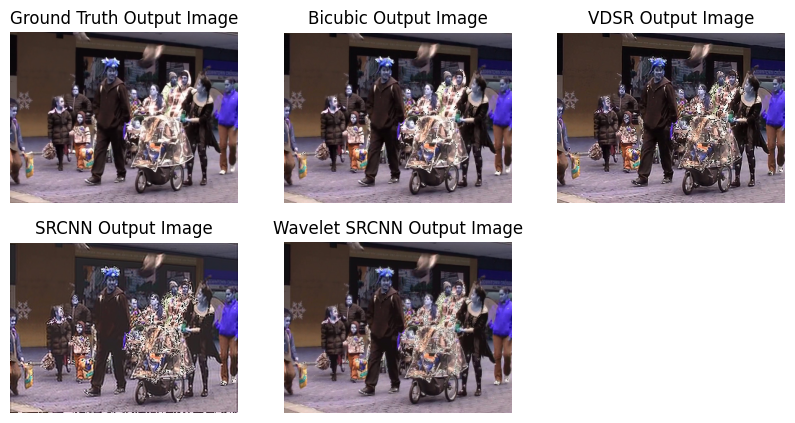

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
plt.title("Ground Truth Output Image")
plt.imshow(Img, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Bicubic Output Image")
plt.imshow(im_B, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("VDSR Output Image")
plt.imshow(im_V, cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("SRCNN Output Image")
plt.imshow(im_SRCNN, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("Wavelet SRCNN Output Image")
plt.imshow(im_WSR, cmap='gray')
plt.axis('off')

In [ ]:
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    mse = np.mean(imdff ** 2)  # Mean squared error
    if mse == 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))  # Using RMSE inside PSNR formula


In [ ]:
im_bic_n = im_B / 255.0
im_gnd_n = Img / 255.0
im_wsr_n = im_WSR / 255.0
im_v_n = im_V / 255.0
im_srcnn_n = im_SRCNN / 255.0

psnr_bic = PSNR(im_bic_n, im_gnd_n)
psnr_vdsr = PSNR(im_v_n, im_gnd_n)
psnr_srcnn = PSNR(im_srcnn_n, im_gnd_n)
psnr_wsr = PSNR(im_wsr_n, im_gnd_n)

print(f'PSNR for Bicubic Interpolation: {psnr_bic:.6f} dB')
print(f'PSNR for SRCNN Reconstruction: {psnr_srcnn:.6f} dB')
print(f'PSNR for VDSR Reconstruction: {psnr_vdsr:.6f} dB')
print(f'PSNR for WSR Reconstruction: {psnr_wsr:.6f} dB')

PSNR for Bicubic Interpolation: 58.768422 dB
PSNR for SRCNN Reconstruction: 58.843388 dB
PSNR for VDSR Reconstruction: 59.063947 dB
PSNR for WSR Reconstruction: 64.939234 dB


In [ ]:
def MSE(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    mse = np.mean(imdff ** 2)  # Average of squared differences
    return mse


In [ ]:
mse_bic = MSE(im_bic_n, im_gnd_n)
mse_wsr = MSE(im_wsr_n, im_gnd_n)
mse_vdsr = MSE(im_v_n, im_gnd_n)
mse_srcnn = MSE(im_srcnn_n, im_gnd_n)

print(f'MSE for Bicubic Interpolation: {mse_bic:.6f} dB')
print(f'MSE for SRCNN Reconstruction: {mse_srcnn:.6f} dB')
print(f'MSE for VDSR Reconstruction: {mse_vdsr:.6f} dB')
print(f'MSE for WSR Reconstruction: {mse_wsr:.6f} dB')


MSE for Bicubic Interpolation: 0.086345 dB
MSE for SRCNN Reconstruction: 0.084868 dB
MSE for VDSR Reconstruction: 0.080665 dB
MSE for WSR Reconstruction: 0.020852 dB


In [ ]:
# Convert numpy arrays to float tensors and permute HWC → CHW
im_wsr_torch = torch.from_numpy(im_wsr_n).float().permute(2, 0, 1)
im_gnd_torch = torch.from_numpy(im_gnd_n).float().permute(2, 0, 1)
im_bic_torch = torch.from_numpy(im_bic_n).float().permute(2, 0, 1)
vdsr_torch = torch.from_numpy(im_v_n).float().permute(2, 0, 1)
im_srcnn_torch = torch.from_numpy(im_srcnn_n).float().permute(2, 0, 1)

# Convert images to 4D tensors (Batch, Channels, Height, Width) and resize
def resize_to(im, size=(480, 640)):
    return F.interpolate(im.unsqueeze(0), size=size, mode="bilinear", align_corners=False)

im_wsr_resized = resize_to(im_wsr_torch)
im_bic_resized = resize_to(im_bic_torch)
vdsr_resized = resize_to(vdsr_torch)
srcnn_resized = resize_to(im_srcnn_torch)
im_gnd_resized = resize_to(im_gnd_torch)  # also resize ground truth to match

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Convert Torch tensors to NumPy arrays (assuming images are 3D: CHW format)
# and bring them back to [0, 255] range if you normalized to [-1, 1]
def to_numpy_uint8(img_tensor):
    img = img_tensor.clone().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))           # CHW -> HWC
    img = ((img + 1) * 127.5).clip(0, 255).astype(np.uint8)  # [-1,1] -> [0,255]
    return img

# Convert all images
gt_np    = to_numpy_uint8(im_gnd_resized[0])    # remove batch dim
bic_np   = to_numpy_uint8(im_bic_resized[0])
srcnn_np = to_numpy_uint8(srcnn_resized[0])
vdsr_np  = to_numpy_uint8(vdsr_resized[0])
wsr_np   = to_numpy_uint8(im_wsr_resized[0])

# Compute SSIM for each model
ssim_bic   = ssim(gt_np, bic_np, channel_axis=2)
ssim_srcnn = ssim(gt_np, srcnn_np, channel_axis=2)
ssim_vdsr  = ssim(gt_np, vdsr_np, channel_axis=2)
ssim_wsr   = ssim(gt_np, wsr_np, channel_axis=2)

# Print results
print("\nSSIM (higher is better):")
print(f"Bicubic vs GT: {ssim_bic:.4f}")
print(f"SRCNN   vs GT: {ssim_srcnn:.4f}")
print(f"VDSR    vs GT: {ssim_vdsr:.4f}")
print(f"WSR     vs GT: {ssim_wsr:.4f}")



SSIM (higher is better):
Bicubic vs GT: 0.7325
SRCNN   vs GT: 0.6675
VDSR    vs GT: 0.6581
WSR     vs GT: 0.7874


In [ ]:
import torch
import pyiqa
import numpy as np

# Helper: Convert NumPy RGB image to normalized torch tensor (1,3,H,W)
def to_tensor(img_np):
    img = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    return img

# Load NIQE and BRISQUE models
niqe_metric = pyiqa.create_metric('niqe')
brisque_metric = pyiqa.create_metric('brisque')

# Convert your images
bic_tensor = to_tensor(bic_np)
srcnn_tensor = to_tensor(srcnn_np)
vdsr_tensor = to_tensor(vdsr_np)
wsr_tensor = to_tensor(wsr_np)

# Compute scores
niqe_bic = niqe_metric(bic_tensor).item()
niqe_srcnn = niqe_metric(srcnn_tensor).item()
niqe_vdsr = niqe_metric(vdsr_tensor).item()
niqe_wsr = niqe_metric(wsr_tensor).item()

brisque_bic = brisque_metric(bic_tensor).item()
brisque_srcnn = brisque_metric(srcnn_tensor).item()
brisque_vdsr = brisque_metric(vdsr_tensor).item()
brisque_wsr = brisque_metric(wsr_tensor).item()

# Print results
print("\nNIQE (lower is better):")
print(f"Bicubic: {niqe_bic:.2f}")
print(f"SRCNN:   {niqe_srcnn:.2f}")
print(f"VDSR:    {niqe_vdsr:.2f}")
print(f"WSR:     {niqe_wsr:.2f}")

print("\nBRISQUE (lower is better):")
print(f"Bicubic: {brisque_bic:.2f}")
print(f"SRCNN:   {brisque_srcnn:.2f}")
print(f"VDSR:    {brisque_vdsr:.2f}")
print(f"WSR:     {brisque_wsr:.2f}")



NIQE (lower is better):
Bicubic: 8.04
SRCNN:   8.03
VDSR:    8.78
WSR:     3.98

BRISQUE (lower is better):
Bicubic: 46.39
SRCNN:   41.92
VDSR:    45.00
WSR:     28.48
